In [1]:
import os
import pickle
import re

from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt

### 全局变量

In [2]:
START_YEAR = 2024
START_MONTH = 4
END_YEAR = 2024
END_MONTH = 4
DATA_FOLDER_PATH = '..\data'


In [3]:
# 设置 Matplotlib 的字体
plt.rcParams['font.family'] = 'SimHei'  # 设置字体为 SimHei
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号


### File I/O

In [4]:
def unpickle(file):
    """
    Unpickle file
    :param file: file path

    :return: dict
    """
    if not os.path.exists(file):
        return {}
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
def load_and_merge_data(start_year, start_month, end_year, end_month):
    """
    Load and merge equity data from specified period into a single DataFrame.

    :param start_year: int, start year
    :param start_month: int, start month
    :param end_year: int, end year
    :param end_month: int, end month

    :return: DataFrame
    """
    all_equity_data = []
    for year in range(start_year, end_year + 1):
        for month in range(start_month, end_month + 1):
            # 构建文件名
            filename = f"momozhen_{year}_{month}.pkl"
            file_path = os.path.join(DATA_FOLDER_PATH, filename)
            data = unpickle(file_path)
            if data and "equity_data" in data:
                all_equity_data.extend(data["equity_data"])

    # 合并所有股权数据到一个 DataFrame
    if all_equity_data:
        return pd.DataFrame(all_equity_data)
    else:
        return pd.DataFrame()
    

### Helper functions

In [6]:
def plot_attribute_percentages(percentages, attribute_name):
    """
    显示给定属性的百分比值的频率图
    """
    if attribute_name not in percentages:
        print(f"No data available for {attribute_name}")
        return
    data = percentages[attribute_name]
    x = list(data.keys())
    y = list(data.values())

    # 计算最小和最大百分比值
    min_percentage = min(x)
    max_percentage = max(x)

    plt.figure(figsize=(10, 6))
    plt.hist(x, bins=range(min_percentage, max_percentage+1), weights=y, color='skyblue') # 属性正常范围应该为 50 - 150%
    plt.xlabel('Percentage')
    plt.ylabel('Frequency')
    plt.title(f'{attribute_name} ({min_percentage} - {max_percentage}%)')
    plt.grid(axis='y')
    plt.show()

In [7]:
def plot_attribute_percentages_all(percentages):
    """
    将所有属性的加成百分比转换为一张百分比频率图
    """
    data = defaultdict(int)
    for attribute_name, attribute_data in percentages.items():
        for percentage, count in attribute_data.items():
            data[percentage] += count

    x = list(data.keys())
    y = list(data.values())

    min_percentage = min(x)
    max_percentage = max(x)

    plt.figure(figsize=(10, 6))
    plt.hist(x, bins=range(min_percentage, max_percentage+1), weights=y, color='skyblue') # 属性正常范围应该为 50 - 150%
    plt.xlabel('Percentage')
    plt.ylabel('Frequency')
    plt.title(f'All attributes ({min_percentage} - {max_percentage}%)')
    plt.grid(axis='y')
    plt.show()

In [8]:
def plot_total_percentage(df):
    """
    显示 装备 的 `total_percentage` 的频率图 (histogram)

    :param df: DataFrame
    """
    x = df['total_percentage']
    min_percentage = int(x.min())
    max_percentage = int(x.max())

    plt.figure(figsize=(10, 6))
    plt.hist(x, bins=range(min_percentage, max_percentage+1), color='skyblue') # total_percentage 正常范围应该为 200 - 700%
    plt.xlabel('总属性')
    plt.ylabel('Frequency')
    plt.title(f'属性合计 ({min_percentage} - {max_percentage})')
    plt.grid(axis='y')
    plt.show()


In [9]:
def plot_level(df):
    """
    显示 装备 等级的频率图 (histogram)

    :param df: DataFrame
    """
    x = df['level']

    min_level = int(x.min())
    max_level = int(x.max())

    plt.figure(figsize=(10, 6))
    plt.hist(x, bins=range(min_level, max_level+1), color='skyblue')
    plt.xlabel('Level')
    plt.ylabel('Frequency')
    plt.title(f'等级分布 ({min_level} - {max_level})')
    plt.grid(axis='y')
    plt.show()

In [10]:
def print_missing_total_percentage(df, num_initial_missing, num_final_missing):
    """
    打印 装备 的 `total_percentage` 缺失的数值
    """
    # 计算最小值和最大值
    min_percentage = df['total_percentage'].min()
    max_percentage = df['total_percentage'].max()

    # 生成完整的整数序列
    full_range = set(range(min_percentage, max_percentage + 1))

    # 找出缺失的数字
    missing_numbers = list(full_range - set(df['total_percentage']))

    # 对缺失的数字进行排序
    missing_numbers.sort()

    if num_initial_missing > 0:
        # 打印前 num_initial_missing 个缺失的值
        print(f"前 {num_initial_missing} 个缺失的值:")
        if len(missing_numbers) > 0:
            print(missing_numbers[0], "// + 0")  # 第一个缺失值
            for i in range(1, min(num_initial_missing, len(missing_numbers))):
                print(missing_numbers[i], "// +", missing_numbers[i] - missing_numbers[i-1])

    if num_final_missing > 0:
        # 打印后 num_final_missing 个缺失的值
        print(f"\n后 {num_final_missing} 个缺失的值:")
        if len(missing_numbers) > 0:
            start_index = max(0, len(missing_numbers) - num_final_missing)
            for i in range(start_index, len(missing_numbers)):
                if i == start_index:
                    print(missing_numbers[i], "// + 0")  # 为了格式对齐，标记为+0
                else:
                    print(missing_numbers[i], "// +", missing_numbers[i] - missing_numbers[i-1])


In [11]:
def plot_pie_chart(df, column):
    """
    绘制给定列的饼图
    """
    # 检查列是否在 DataFrame 中
    if column not in df:
        print(f"Column '{column}' not found in the DataFrame.")
        return
    
    # 按照 momozhen 网站 css 颜色定义
    color_map = {
        "黑色": "dimgrey",   # 灰色, TODO: 不确定
        "红色": "#ea644a",
        "黄色": "#f1a325",
        "绿色": "#38b03f",
        "蓝色": "#03b8cf"
    }
    # 计算每个类别的计数
    data = df[column].value_counts()
    # 分配颜色：如果在 color_map 中则使用预定义颜色，否则随机生成颜色
    colors = [color_map.get(x, plt.cm.tab20.colors[i % len(plt.cm.tab20.colors)]) for i, x in enumerate(data.index)]


    # 创建饼图，无标签显示在图中
    plt.figure(figsize=(12, 6))
    plt.subplot(121)  # 定义一个1行2列的子图，并在第1个位置绘图
    patches, texts, autotexts = plt.pie(data, colors=colors, autopct='%1.1f%%', startangle=140)

    # 去除饼图中的标签
    for text in texts + autotexts:
        text.set_visible(False)

    plt.title(f'Pie Chart of {column}')

    # 创建图例，显示颜色、标签和百分比
    plt.subplot(122)  # 在第2个位置绘图
    legend_labels = [f"{label}: {perc.get_text()}" for label, perc in zip(data.index, autotexts)]
    plt.axis('off')  # 关闭坐标轴
    plt.legend(patches, legend_labels, loc='center', frameon=False)

    plt.tight_layout()
    plt.show()

### 数据分析

In [12]:
# 使用函数加载和合并数据
df = load_and_merge_data(START_YEAR, START_MONTH, END_YEAR, END_MONTH)

In [13]:
# 为 df 添加 df['mysterious'] 列, 依照 attributes list 中只要一项存在字符 '神秘属性'
df['mysterious'] = df['attributes'].apply(lambda x: any('神秘属性' in s for s in x))

In [ ]:
# 从 attributes 中提取每项属性的加成百分比 (先检查是否存在 '神秘属性' 词条, 如果存在则不提取, 单独统计出现次数)
mysterious_count = 0
attr_perc_dict = defaultdict(lambda: defaultdict(int))

attribute_pattern = re.compile(r'([^\[]+)\s+\+(\d+\.?\d*)\s+\((\d+)%\)')


In [ ]:
for attributes in df['attributes']:
	for attribute in attributes:
		if '神秘属性' in attribute:
			mysterious_count += 1
		else:
			match = attribute_pattern.match(attribute)
			if match:
				attr_name = match.group(1).strip()
				percent = int(match.group(3))
				attr_perc_dict[attr_name][percent] += 1

In [ ]:
print(f"神秘属性出现次数: {mysterious_count}")

In [ ]:
plot_attribute_percentages(attr_perc_dict, '附加物防')

In [ ]:
plot_attribute_percentages_all(attr_perc_dict)

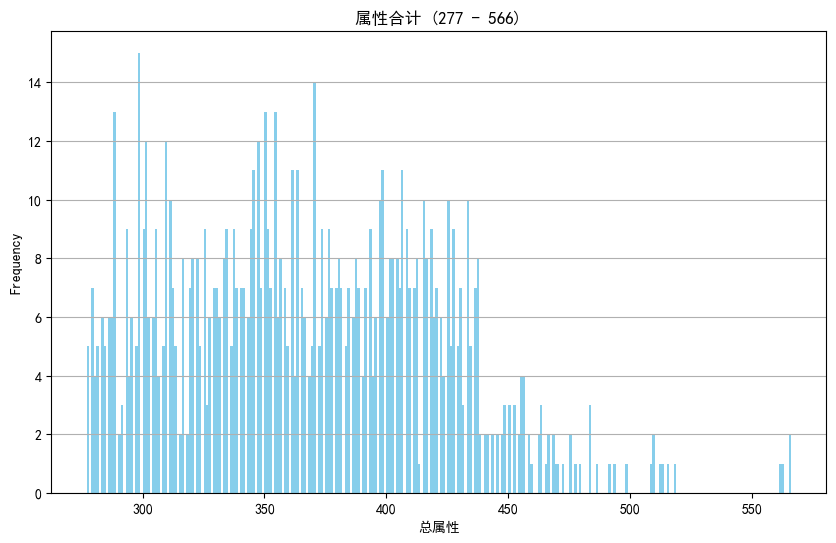

In [14]:
plot_total_percentage(df)


In [15]:
num_initial_missing = 10
num_final_missing = 0

print_missing_total_percentage(df, num_initial_missing, num_final_missing)


前 10 个缺失的值:
278 // + 0
282 // + 4
285 // + 3
289 // + 4
292 // + 3
296 // + 4
299 // + 3
303 // + 4
307 // + 4
310 // + 3


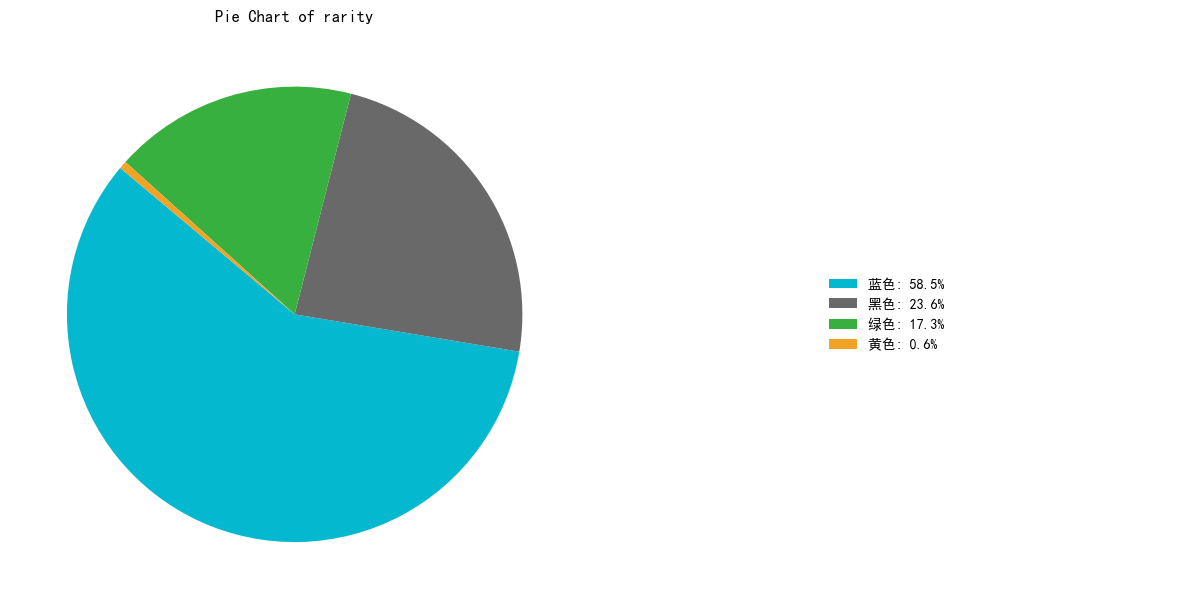

In [16]:
plot_pie_chart(df, 'rarity')

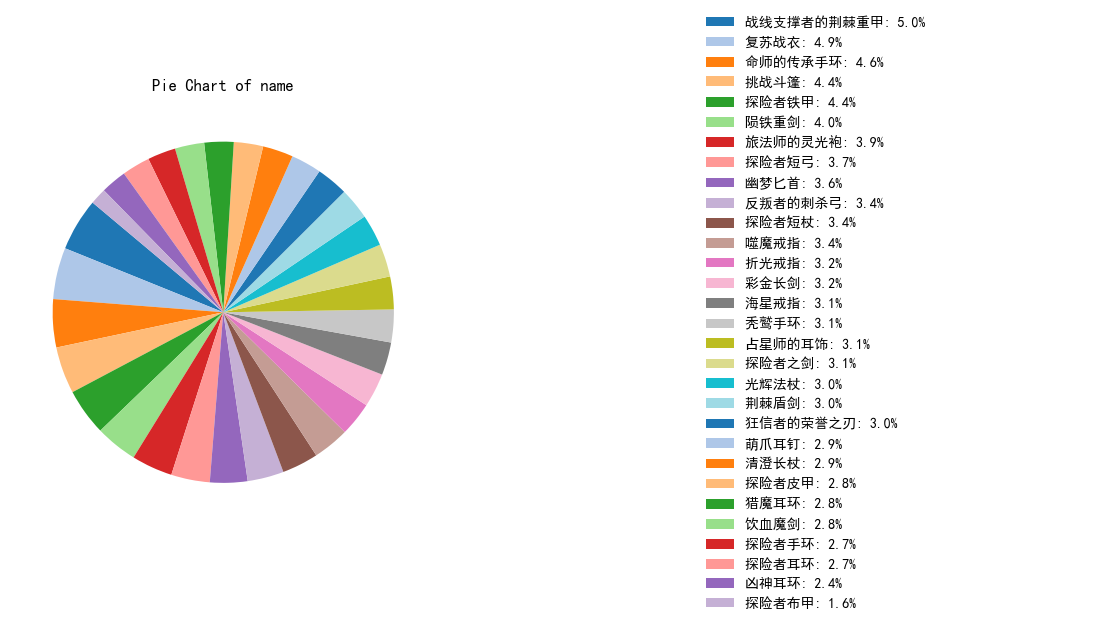

In [17]:
plot_pie_chart(df, 'name')

In [ ]:
plot_level(df)


In [ ]:
# 将装备按照有无神秘分成两堆
mysterious_df = df[df['mysterious'] == True]
non_mysterious_df = df[df['mysterious'] == False]